Program for Parameter transfer and Selective Layer optimization in different noise types and different cicuit depth of QAOA. Here 2nd layer is being optimized but for the circuit of depth 1, there is no second layer so for those cases the first layer is optimized and all the other layers are unoptimized.

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize
from scipy import linalg

from qiskit.quantum_info import Kraus
from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,  # for T1 error
    phase_damping_error,  # for T2 error
    depolarizing_error,  # for Gate error
    pauli_error,
)

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


Function to calculate expectation value of Hamiltonian w.r.t. the quantum circuit. 

In [109]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Donor Graph which will be fully optimized using QAOA of depth p and then it's optimized parameters will be trasferred into acceptor graph as initial parameters

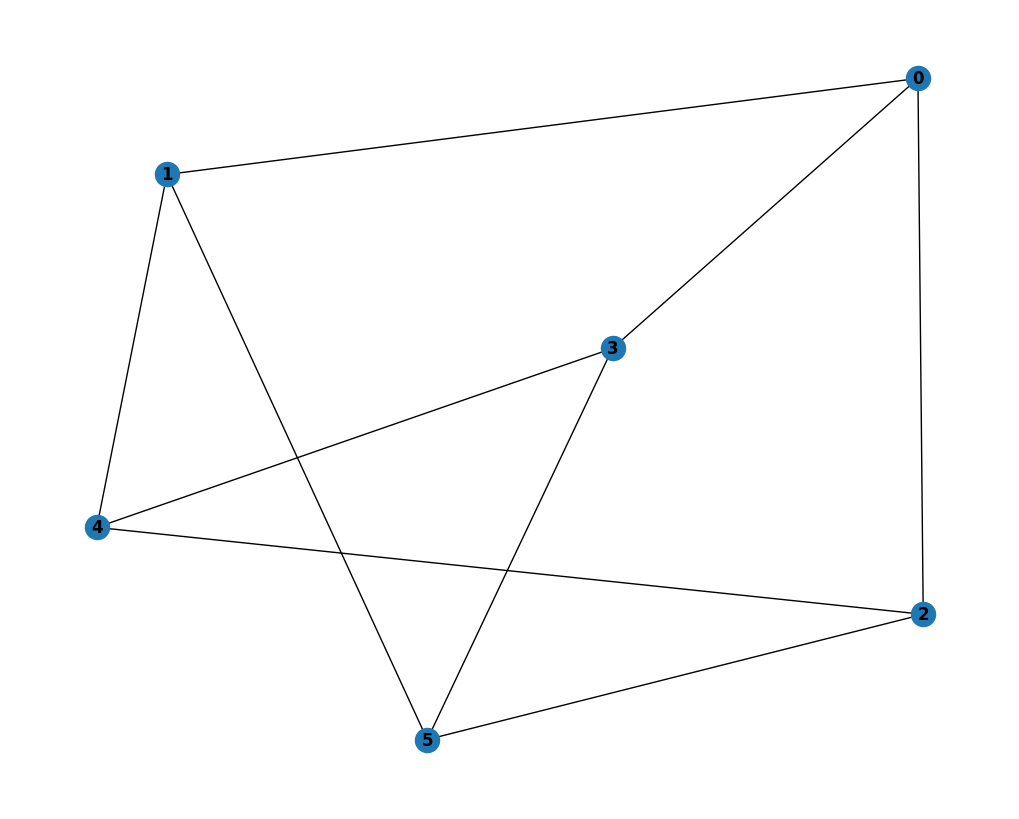

In [110]:
# make sure dxn is even for d-regular graph.
n1 = 6  # number of vertices
d = 3  #  d-regular graph
p = 5  # QAOA layers

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G1 = nx.random_regular_graph(d ,n1)
for (u,v) in G1.edges():
    G1[u][v]['weight'] = 1.0

edges1 = G1.edges()
nx.draw(G1, with_labels=True, font_weight='bold')

# weight matrix
w1 = np.zeros([n1,n1])
for (u,v) in G1.edges():
    w1[u][v] = G1[u][v]['weight']
    w1[v][u] = G1[u][v]['weight']
#print(w1)
plt.savefig('donor graph.pdf', dpi=300, bbox_inches='tight')
plt.close
plt.show()


Exact Maxcut value for donor graph using classical brute force method

In [111]:
# classical solution
sol1 = 0
for b in range(2**n1):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n1)))]
    Cut_value1 = 0
    for i in range(n1):
        for j in range(n1):
            Cut_value1 += w1[i][j]*x1[i]*(1-x1[j])
    if sol1 < Cut_value1:
        sol1 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol1}")

Classical solution: 9.0


converting classical maxcut problem into cost Hamiltonian

In [112]:
prob=Maxcut(w1)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian1, offset1 = qubo.to_ising()
print('offset:', offset1)
print(cost_hamiltonian1)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_4 - 2*x_1*x_5 - 2*x_2*x_4
  - 2*x_2*x_5 - 2*x_3*x_4 - 2*x_3*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_2 + 2*x_0*x_3 + 2*x_1*x_4 + 2*x_1*x_5 + 2*x_2*x_4
  + 2*x_2*x_5 + 2*x_3*x_4 + 2*x_3*x_5 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

offset: -4.5
SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIZI', 'ZIIIZI', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


Acceptor graph which takes the optimized parameters of donor graph as acceptor graph then only a single layer is optimized in QAOA

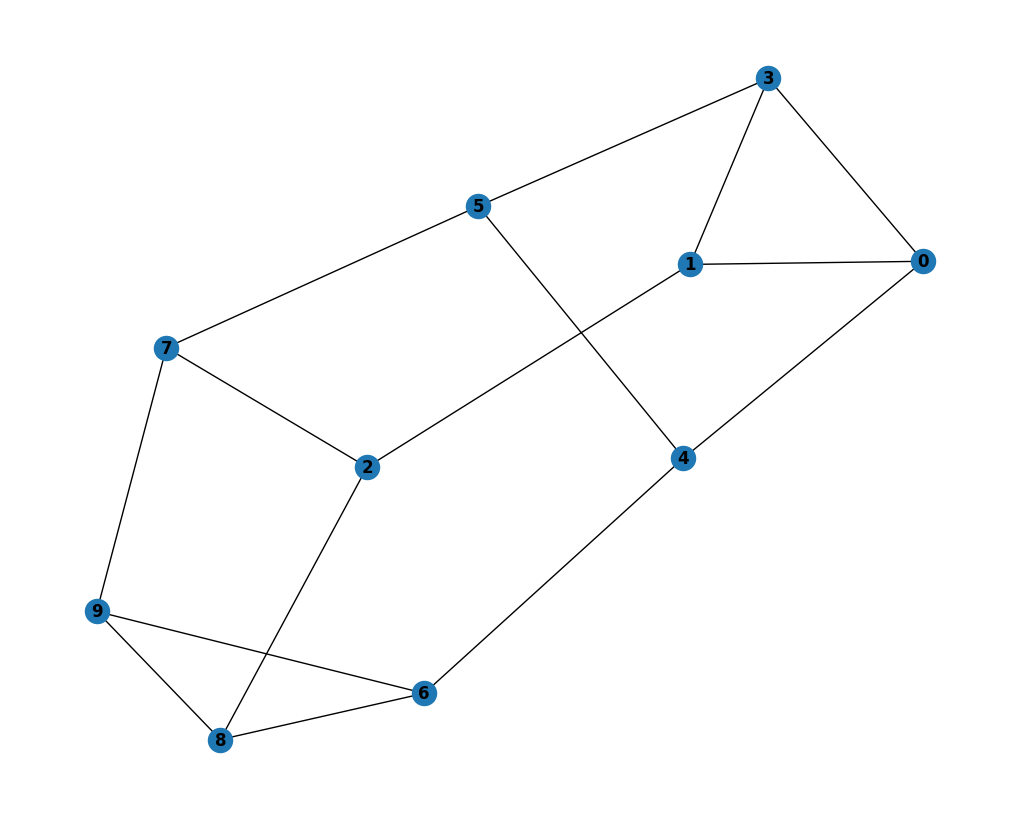

In [113]:
# make sure dxn is even for d-regular graph.
n2 = 10  # number of vertices

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G2 = nx.random_regular_graph(d ,n2)
for (u,v) in G2.edges():
    G2[u][v]['weight'] = 1.0

edges = G2.edges()
nx.draw(G2, with_labels=True, font_weight='bold')

# weight matrix
w2 = np.zeros([n2,n2])
for (u,v) in G2.edges():
    w2[u][v] = G2[u][v]['weight']
    w2[v][u] = G2[u][v]['weight']

Classical maxcut value for acceptor graph

In [114]:
# classical solution
sol2 = 0
for b in range(2**n2):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n2)))]
    Cut_value1 = 0
    for i in range(n2):
        for j in range(n2):
            Cut_value1 += w2[i][j]*x1[i]*(1-x1[j])
    if sol2 < Cut_value1:
        sol2 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol2}")

Classical solution: 13.0


Cost Hamiltonian for acceptor graph

In [115]:
prob=Maxcut(w2)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian2, offset2 = qubo.to_ising()
print('offset: ',offset2)
print(cost_hamiltonian2)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_2*x_7
  - 2*x_2*x_8 - 2*x_3*x_5 - 2*x_4*x_5 - 2*x_4*x_6 - 2*x_5*x_7 - 2*x_6*x_8
  - 2*x_6*x_9 - 2*x_7*x_9 - 2*x_8*x_9 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5 + 3*x_6 + 3*x_7 + 3*x_8 + 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_3 + 2*x_0*x_4 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_7
  + 2*x_2*x_8 + 2*x_3*x_5 + 2*x_4*x_5 + 2*x_4*x_6 + 2*x_5*x_7 + 2*x_6*x_8
  + 2*x_6*x_9 + 2*x_7*x_9 + 2*x_8*x_9 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5 - 3*x_6 - 3*x_7 - 3*x_8 - 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

offset:  -7.5
SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIZIIIIZII', 'IZIIIIIZII', 'IIIIZIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZIZIIIII', 'IZIZIIIIII', 'ZIIZIII

Function which is used to calculate the expectation value of cost Hamiltonian using parameters of a single layer which is to be optimized

In [116]:
def cost_func_estimator_selective(params, ansatz, tra_params, hamiltonian, estimator, m, tp):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    sel_par = tra_params.copy()
    sel_par[m] = params[0]
    sel_par[tp+m] = params[1]
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, sel_par)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

defining an array for varying noise parameter

In [117]:
err = np.linspace(1e-5,1e-2,10)

matrices to store cost values for different noise

In [118]:
cost_ideal = np.zeros([p, len(err)])
cost_phf = np.zeros([p, len(err)])
cost_bif = np.zeros([p, len(err)])
cost_phd = np.zeros([p, len(err)])
cost_amd = np.zeros([p, len(err)])
cost_dep = np.zeros([p, len(err)])
cost_com = np.zeros([p, len(err)])

Matrices to store fidelity for different noise

In [119]:
fid_ideal = np.zeros([p, len(err)])
fid_phf = np.zeros([p, len(err)])
fid_bif = np.zeros([p, len(err)])
fid_phd = np.zeros([p, len(err)])
fid_amd = np.zeros([p, len(err)])
fid_dep = np.zeros([p, len(err)])
fid_com = np.zeros([p, len(err)])

In [ ]:
for jj in range(1, p+1, 1):  # Different circuit depth in QAOA

    # Initializing the parameters for our quanutum circuit 
    # using Trotterized Quantum Annealing Initialization method.
    init_params = np.zeros(2*jj)
    tt = 0.75
    for i in range(0, jj, 1):
        init_params[i] = (1.0-i/jj)*tt
        init_params[i+jj] = (i/jj)*tt

    # Preparing circuit for donor graph
    circuit1 = QAOAAnsatz(cost_operator=cost_hamiltonian1, reps=jj)
    circuit1.measure_all()

    #--------------------------------------------------------------------------------
    # Ideal Case for donor graph to get optimized parameters to transfer
    sim_ideal = AerSimulator()
    pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
    candidate_circuit5 = pm5.run(circuit1)

    with Session(backend=sim_ideal) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        result5 = minimize(
            cost_func_estimator,
            init_params,
            args=(candidate_circuit5, cost_hamiltonian1, estimator),
            method="COBYLA",
            tol=1e-3,
        )
    
    # Transferring optimized parameters of donor graph into acceptor graph QAOA initial parameters
    tra_params = result5.x

    #--------------------------------------------------------------------------------
    # Preparing circuit for acceptor graph
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian2, reps=jj)
    circuit.measure_all()

    # Ideal Case
    sim_ideal = AerSimulator(method='density_matrix')
    pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
    candidate_circuit3 = pm5.run(circuit)

    if jj == 1: # If cicuit depth is 1
        sl = 0  # optimize first layer
    else:  # is circuit depth is more than 1
        sl = 1  # optimize second layer

    # parameter of optimizable layer which will be optimized
    opt_par = [tra_params[sl], tra_params[jj+sl]]

    # QAOA run
    with Session(backend=sim_ideal) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        result3 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit3, tra_params, cost_hamiltonian2, estimator, sl, jj),
            method="COBYLA",
            tol=1e-3,
        )

    # updating parameters
    new_par = tra_params.copy()
    new_par[sl] = result3.x[0]
    new_par[jj+sl] = result3.x[1]
   
    # creating circuit with these updated parameters without measurement to get density matrix
    qaoa_circuit_ideal = candidate_circuit3.remove_final_measurements(inplace=False).assign_parameters(new_par)  # assigning optimum parameters
    qaoa_circuit_ideal.save_density_matrix(qubits=range(n2), label='rho_ideal')
    result_ideal= sim_ideal.run(transpile(qaoa_circuit_ideal, sim_ideal)).result()
    rho_ideal = result_ideal.data()['rho_ideal']  # superposition state\
    ideal_cost_val = offset2+np.real(np.trace(rho_ideal @ cost_hamiltonian2.to_matrix()))

    # storing fidelity and cost value for ideal case
    for ii in range(len(err)):
        rho1 = linalg.sqrtm(rho_ideal)
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_ideal.data@rho1.data))
        fid_ideal[jj-1][ii] = (np.abs(fidelity**2))
        cost_ideal[jj-1][ii] = -ideal_cost_val/sol2
    
    # now introducing differnt noise
    for kk in range(0, len(err), 1):
        # 1-qubit Error
        err_phf = pauli_error([("Z", err[kk]), ("I", 1 - err[kk])]) # phase-flip 
        err_bif = pauli_error([("X", err[kk]), ("I", 1 - err[kk])]) # bit-flip
        err_amd = amplitude_damping_error(err[kk]) # amplitude-damping
        err_phd = phase_damping_error(err[kk]) # phase-damping
        err_dep_1q = depolarizing_error(err[kk], num_qubits=1) # Depolarizing

        # 2-qubit Error
        err_phf_2q = err_phf.tensor(err_phf) # phase-flip 
        err_bif_2q = err_bif.tensor(err_bif) # bit-flip
        err_amd_2q = err_amd.tensor(err_amd) # amplitude-damping
        err_phd_2q = err_phd.tensor(err_phd) # phase-damping
        err_dep_2q = depolarizing_error(err[kk], num_qubits=2) # Depolarizing

        # combining all 1-qubit errors
        err_all_1q = err_phf.compose(err_bif).compose(err_amd).compose(err_phd).compose(err_dep_1q)
        # Combining all 2-qubit errors
        err_all_2q = err_phf.compose(err_bif_2q).compose(err_amd_2q).compose(err_phd_2q).compose(err_dep_2q)

        #---------------------------------------------------------------------------------------------------
        # Phase Flip error
        noise_model_phf = NoiseModel()
        noise_model_phf.add_all_qubit_quantum_error(err_phf, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
        noise_model_phf.add_all_qubit_quantum_error(err_phf_2q, ['cx'])  # 2-qubit err[kk] gate specifications

        sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_phf)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit2 = pm1.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[sl], tra_params[jj+sl]]
            result4 = minimize(
                cost_func_estimator_selective,
                opt_par,
                args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
                method="COBYLA",
                tol=1e-3,
            )

        new_par = tra_params.copy()
        new_par[sl] = result4.x[0]
        new_par[jj+sl] = result4.x[1]

        qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
        qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
        result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
        rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
        fid_phf[jj-1][kk] = np.abs(fidelity**2)  # Fidelity

        cost_phf[jj-1][kk] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

        # -----------------------------------------------------------------------------------------------
        # Bit-flip error
        noise_model_bif = NoiseModel()
        noise_model_bif.add_all_qubit_quantum_error(err_bif, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
        noise_model_bif.add_all_qubit_quantum_error(err_bif_2q, ['cx'])  # 2-qubit err[kk] gate specifications

        sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_bif)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit2 = pm1.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[sl], tra_params[jj+sl]]
            result4 = minimize(
                cost_func_estimator_selective,
                opt_par,
                args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
                method="COBYLA",
                tol=1e-3,
            )

        new_par = tra_params.copy()
        new_par[sl] = result4.x[0]
        new_par[jj+sl] = result4.x[1]

        qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
        qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
        result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
        rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
        fid_bif[jj-1][kk] = np.abs(fidelity**2)  # Fidelity
        cost_bif[jj-1][kk] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

        # -----------------------------------------------------------------------------------------------
        # Phase damping error
        noise_model_phd = NoiseModel()
        noise_model_phd.add_all_qubit_quantum_error(err_phd, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
        noise_model_phd.add_all_qubit_quantum_error(err_phd_2q, ['cx'])  # 2-qubit err[kk] gate specifications

        sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_phd)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit2 = pm1.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[sl], tra_params[jj+sl]]
            result4 = minimize(
                cost_func_estimator_selective,
                opt_par,
                args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
                method="COBYLA",
                tol=1e-3,
            )

        new_par = tra_params.copy()
        new_par[sl] = result4.x[0]
        new_par[jj+sl] = result4.x[1]

        qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
        qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
        result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
        rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
        fid_phd[jj-1][kk] = np.abs(fidelity**2)  # Fidelity
        cost_phd[jj-1][kk] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

        # -------------------------------------------------------------------------------------------------
        # Amplitude Damping Error
        noise_model_amd = NoiseModel()
        noise_model_amd.add_all_qubit_quantum_error(err_amd, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
        noise_model_amd.add_all_qubit_quantum_error(err_amd_2q, ['cx'])  # 2-qubit err[kk] gate specifications

        sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_amd)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit2 = pm1.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[sl], tra_params[jj+sl]]
            result4 = minimize(
                cost_func_estimator_selective,
                opt_par,
                args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
                method="COBYLA",
                tol=1e-3,
            )

        new_par = tra_params.copy()
        new_par[sl] = result4.x[0]
        new_par[jj+sl] = result4.x[1]

        qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
        qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
        result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
        rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
        fid_amd[jj-1][kk] = np.abs(fidelity**2)  # Fidelity
        cost_amd[jj-1][kk] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

        # ---------------------------------------------------------------------------------------------
        # Depolarizing Noise
        noise_model_dep = NoiseModel()
        noise_model_dep.add_all_qubit_quantum_error(err_dep_1q, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
        noise_model_dep.add_all_qubit_quantum_error(err_dep_2q, ['cx'])  # 2-qubit err[kk] gate specifications

        sim_all = AerSimulator(method='density_matrix', noise_model = noise_model_dep)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit2 = pm1.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[sl], tra_params[jj+sl]]
            result4 = minimize(
                cost_func_estimator_selective,
                opt_par,
                args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
                method="COBYLA",
                tol=1e-3,
            )
    
        new_par = tra_params.copy()
        new_par[sl] = result4.x[0]
        new_par[jj+sl] = result4.x[1]

        qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
        qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
        result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
        rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
        fid_dep[jj-1][kk] = np.abs(fidelity**2)  # Fidelity
        cost_dep[jj-1][kk] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))

        # -----------------------------------------------------------------------------------------------
        # All Noise Combined
        # Noise Model
        noise_all = NoiseModel()
        noise_all.add_all_qubit_quantum_error(err_all_1q, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
        noise_all.add_all_qubit_quantum_error(err_all_2q, ['cx'])  # 2-qubit err[kk] gate specifications

        sim_all = AerSimulator(method='density_matrix', noise_model = noise_all)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit2 = pm1.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[sl], tra_params[jj+sl]]
            result4 = minimize(
                cost_func_estimator_selective,
                opt_par,
                args=(candidate_circuit2, tra_params, cost_hamiltonian2, estimator, sl, jj),
                method="COBYLA",
                tol=1e-3,
            )
    
        new_par = tra_params.copy()
        new_par[sl] = result4.x[0]
        new_par[jj+sl] = result4.x[1]

        qaoa_circuit_noise = candidate_circuit2.remove_final_measurements(inplace=False).assign_parameters(new_par)
        qaoa_circuit_noise.save_density_matrix(qubits=range(n2), label='rho_noise')
        result_noise = sim_all.run(transpile(qaoa_circuit_noise, sim_all)).result()
        rho_noise = result_noise.data()['rho_noise']  # noisy density matrix
        fidelity = np.trace(linalg.sqrtm(rho1.data@rho_noise.data@rho1.data))
        fid_com[jj-1][kk] = np.abs(fidelity**2)  # Fidelity
        cost_com[jj-1][kk] = offset2+np.real(np.trace(rho_noise @ cost_hamiltonian2.to_matrix()))
    
    print('iteration done :', jj)


iteration done : 1
iteration done : 2
iteration done : 3
iteration done : 4
iteration done : 5


Plotting the Cost function accuracy ($<H_C>/C_{max}$) with noise for different layer

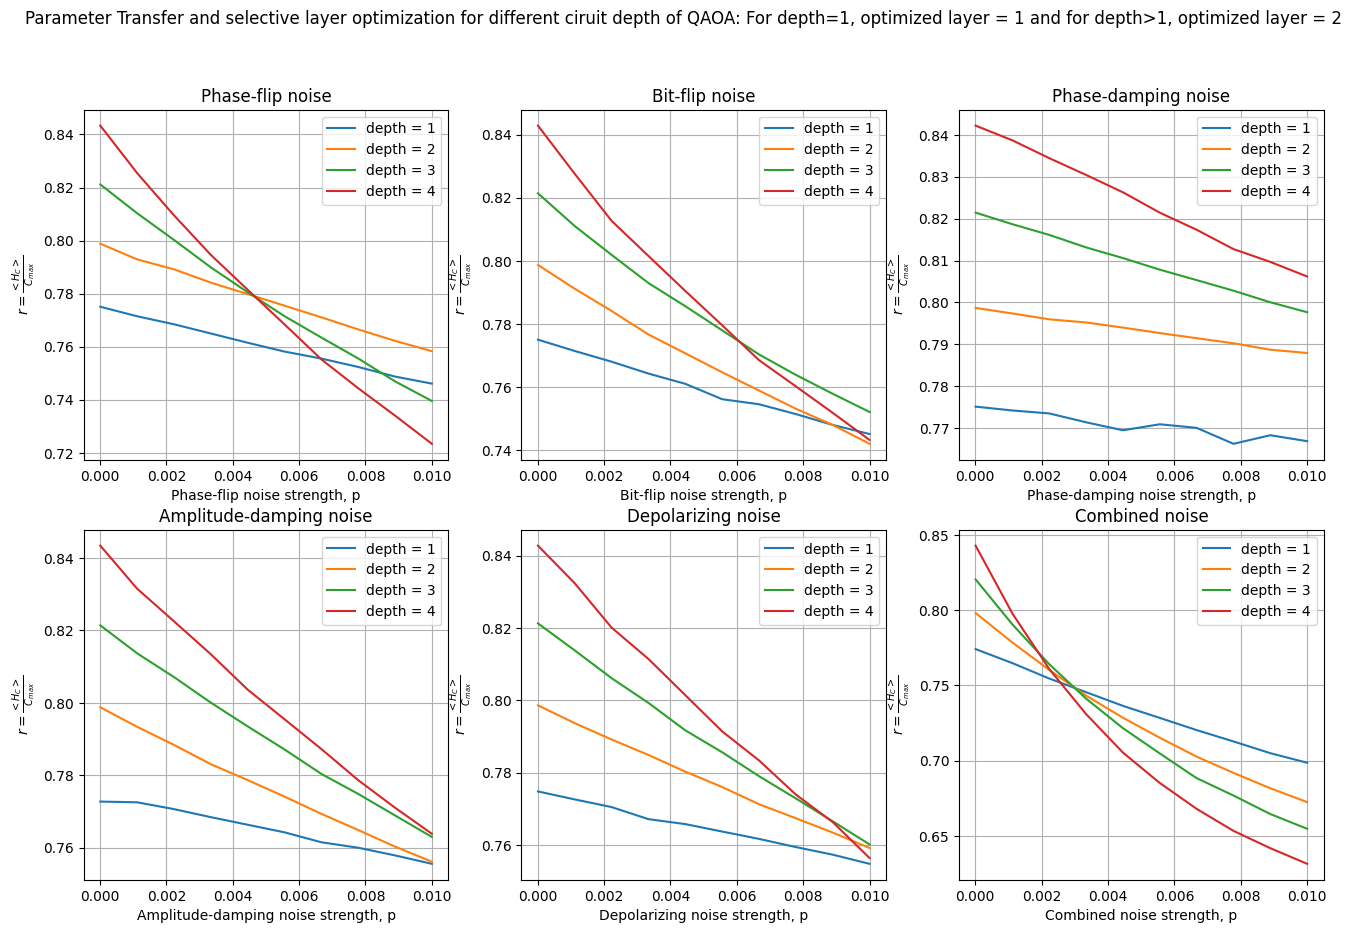

In [146]:
plt.figure(figsize=(16,10))
plt.suptitle('Parameter Transfer and selective layer optimization for different ciruit depth of QAOA' \
': For depth=1, optimized layer = 1 and for depth>1, optimized layer = 2')
plt.subplot(2,3,1)
for i in range(0, p-1, 1):
    plt.plot(err, -cost_phf[i]/sol2, label=f'depth = {i+1}')
plt.title('Phase-flip noise')
plt.xlabel('Phase-flip noise strength, p')
plt.ylabel('$r=\\frac{<H_C>}{C_{max}}$')
plt.grid()
plt.legend()

plt.subplot(2,3,2)
for i in range(0, p-1, 1):
    plt.plot(err, -cost_bif[i]/sol2, label=f'depth = {i+1}')
plt.title('Bit-flip noise')
plt.xlabel('Bit-flip noise strength, p')
plt.ylabel('$r=\\frac{<H_C>}{C_{max}}$')
plt.grid()
plt.legend()

plt.subplot(2,3,3)
for i in range(0, p-1, 1):
    plt.plot(err, -cost_phd[i]/sol2, label=f'depth = {i+1}')
plt.title('Phase-damping noise')
plt.xlabel('Phase-damping noise strength, p')
plt.ylabel('$r=\\frac{<H_C>}{C_{max}}$')
plt.grid()
plt.legend()

plt.subplot(2,3,4)
for i in range(0, p-1, 1):
    plt.plot(err, -cost_amd[i]/sol2, label=f'depth = {i+1}')
plt.title('Amplitude-damping noise')
plt.xlabel('Amplitude-damping noise strength, p')
plt.ylabel('$r=\\frac{<H_C>}{C_{max}}$')
plt.grid()
plt.legend()

plt.subplot(2,3,5)
for i in range(0, p-1, 1):
    plt.plot(err, -cost_dep[i]/sol2, label=f'depth = {i+1}')
plt.title('Depolarizing noise')
plt.xlabel('Depolarizing noise strength, p')
plt.ylabel('$r=\\frac{<H_C>}{C_{max}}$')
plt.grid()
plt.legend()

plt.subplot(2,3,6)
for i in range(0, p-1, 1):
    plt.plot(err, -cost_com[i]/sol2, label=f'depth = {i+1}')
plt.title('Combined noise')
plt.xlabel('Combined noise strength, p')
plt.ylabel('$r=\\frac{<H_C>}{C_{max}}$')
plt.grid()
plt.legend()
plt.savefig('Cost accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()

Plotting fidelity for different noise

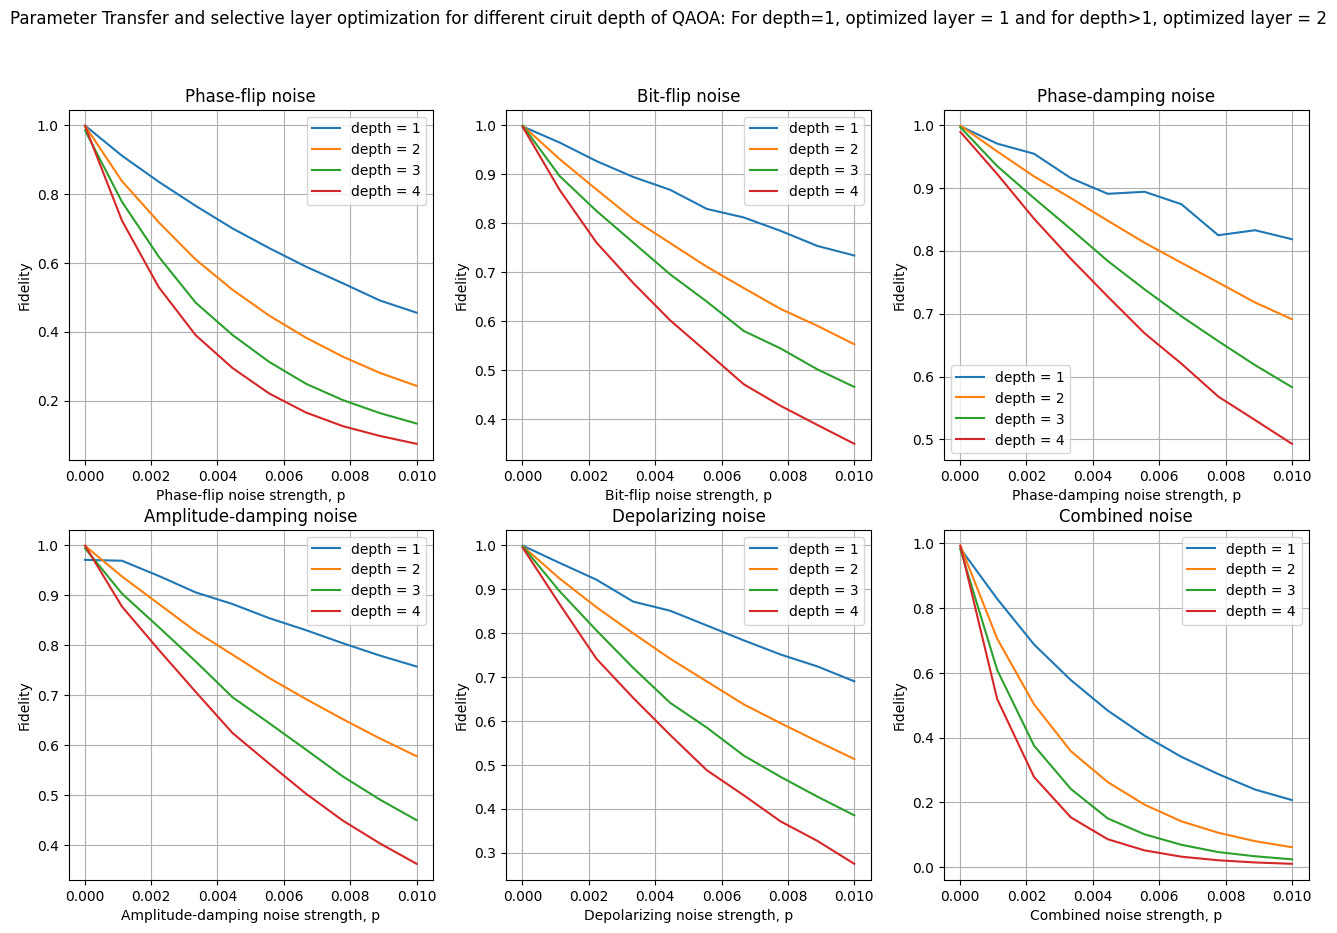

In [147]:
plt.figure(figsize=(16,10))
plt.suptitle('Parameter Transfer and selective layer optimization for different ciruit depth of QAOA' \
': For depth=1, optimized layer = 1 and for depth>1, optimized layer = 2')
plt.subplot(2,3,1)
for i in range(0, p-1, 1):
    plt.plot(err, fid_phf[i], label=f'depth = {i+1}')
plt.title('Phase-flip noise')
plt.xlabel('Phase-flip noise strength, p')
plt.ylabel('Fidelity')
plt.grid()
plt.legend()

plt.subplot(2,3,2)
for i in range(0, p-1, 1):
    plt.plot(err, fid_bif[i], label=f'depth = {i+1}')
plt.title('Bit-flip noise')
plt.xlabel('Bit-flip noise strength, p')
plt.ylabel('Fidelity')
plt.grid()
plt.legend()

plt.subplot(2,3,3)
for i in range(0, p-1, 1):
    plt.plot(err, fid_phd[i], label=f'depth = {i+1}')
plt.title('Phase-damping noise')
plt.xlabel('Phase-damping noise strength, p')
plt.ylabel('Fidelity')
plt.grid()
plt.legend()

plt.subplot(2,3,4)
for i in range(0, p-1, 1):
    plt.plot(err, fid_amd[i], label=f'depth = {i+1}')
plt.title('Amplitude-damping noise')
plt.xlabel('Amplitude-damping noise strength, p')
plt.ylabel('Fidelity')
plt.grid()
plt.legend()

plt.subplot(2,3,5)
for i in range(0, p-1, 1):
    plt.plot(err, fid_dep[i], label=f'depth = {i+1}')
plt.title('Depolarizing noise')
plt.xlabel('Depolarizing noise strength, p')
plt.ylabel('Fidelity')
plt.grid()
plt.legend()

plt.subplot(2,3,6)
for i in range(0, p-1, 1):
    plt.plot(err, fid_com[i], label=f'depth = {i+1}')
plt.title('Combined noise')
plt.xlabel('Combined noise strength, p')
plt.ylabel('Fidelity')
plt.grid()
plt.legend()
plt.savefig('Fidelity.pdf', dpi=300, bbox_inches='tight')
plt.show()